<a href="https://colab.research.google.com/github/Kienknu/Kienknu/blob/main/K_SOA_Toluene_0422_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Number of iteration: n = 1

In [1]:
!pip install rdkit
!pip install molmass

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdChemReactions
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import display
from rdkit.Chem import Descriptors
import pandas as pd
import requests
import io
from molmass import Formula

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 3.1 MB/s eta 0:00:00


#1. Reactions of Toluene with different species

In [2]:
chemical_space_1 = {'Cc1ccccc1'}  # Toluene

reacting_species_1 = {'[OH]', '[N](=O)', '[N+](=O)[O-]', 'O=O', 'N([H])([H])[H]'}
num_iterations_1 = 5

In [3]:
# Reaction rules_1

reaction_rules_1 = [

    AllChem.ReactionFromSmarts('[cH:1]>>[cH:1][*]'),#37/37 ()
    AllChem.ReactionFromSmarts('[cH:1]>>[cH:1][OH]'),#242/242
    AllChem.ReactionFromSmarts('[cH:1]>>[cH:1][N+](=O)[O-]'),#769/992
    AllChem.ReactionFromSmarts('[cH:1]>>[cH:1][N](=O)'),#2322/2998
    AllChem.ReactionFromSmarts('[cH:1]>>[cH:1][NH2]'),#5748/7427
    AllChem.ReactionFromSmarts('[cH:1]>>[cH:1][O][O]'),#12262/16022
]

In [4]:
# Function to create aromatic radical
def create_aromatic_radical(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    radical = Chem.MolFromSmarts("[c*]")

    if mol.HasSubstructMatch(radical):
      return Chem.MolToSmiles(mol)
    else:
      return None


# Reaction for chemical_space_1
reaction_history_1 = []
for _ in range(num_iterations_1):
    temp_new_products = set()
    for reactant_smiles in chemical_space_1.copy():
        reactant_mol = Chem.MolFromSmiles(reactant_smiles)
        if reactant_mol:

            # Apply reaction rules
            for rxn_index, rxn in enumerate(reaction_rules_1):
                possible_products = rxn.RunReactants((reactant_mol,))
                for prod_set in possible_products:
                    for prod in prod_set:
                        try:
                            prod_smiles = Chem.MolToSmiles(prod)
                            prod_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles), canonical=True) # Add canonicalization

                            # radical correction
                            if "[c*]" in prod_smiles:
                                prod_smiles = create_aromatic_radical(reactant_smiles)

                            #Check and add to temp_new_products and reaction_history
                            if prod_smiles not in chemical_space_1:
                                temp_new_products.add(prod_smiles)
                                reaction_history_1.append((reactant_smiles, rxn_index, prod_smiles))
                        except:
                            pass

            # React with reacting species
            for species in reacting_species_1:
                try:
                    combined_smiles = reactant_smiles #+ "." + species
                    combined_mol = Chem.MolFromSmiles(combined_smiles)

                    if combined_mol:

                        temp_new_products.add(Chem.MolToSmiles(combined_mol))
                except:
                    pass

    chemical_space_1.update(temp_new_products)

# Create mols_1 and valid_smiles_1 from chemical_space_1
mols_1 = [Chem.MolFromSmiles(smi) for smi in chemical_space_1]
valid_smiles_1 = list(chemical_space_1)

In [5]:
print(len(chemical_space_1))
print(len(mols_1))

8575
8575


In [6]:
# Experiment file
url = "https://docs.google.com/spreadsheets/d/1pBx8tnFjT5FHe-KaPjAOxNMYgYAr6ie-/edit?usp=sharing&ouid=105784435570061437896&rtpof=true&sd=true"

# spreadsheet ID
spreadsheet_id = url.split("/d/")[1].split("/")[0]

# Excel export URL
excel_export_url = f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=xlsx"

# Download
response = requests.get(excel_export_url)
response.raise_for_status()

# Read
exp_data = pd.read_excel(io.BytesIO(response.content), sheet_name='Tol_NH3_CHON', engine='openpyxl')

exp_data.head()

,Class,DBE,Neutral_DBE,Formula,Exp_m/z,neutral_mass,pos_mass,Mono_Abund,Total_Abund,Calc_m/z,#C,#H,#N,#O,#S,H/C,N/C,O/C,S/C,Osc
0,NO4,5.5,5,C7H7NO4,168.030370,169.038195,170.045995,84906561.99,91434808.22,168.030231,7,7,1,4,0,1.0000,0.1429,0.5714,0,-0.4286
1,NO4,5.5,5,C6H5NO4,154.014731,155.022556,156.030356,61072644.65,64970660.40,154.014581,6,5,1,4,0,0.8333,0.1667,0.6667,0,-0.1666
2,N2O6,6.5,6,C7H6N2O6,213.015519,214.023344,215.031144,15825731.09,17159318.81,213.015309,7,6,2,6,0,0.8571,0.2857,0.8571,0,0.0000
3,N2O10,3.5,3,C7H12N2O10,283.042127,284.049952,285.057752,13027120.30,14047110.36,283.041918,7,12,2,10,0,1.7143,0.2857,1.4286,0,-0.2857
4,N3O13,3.5,3,C7H13N3O13,346.037477,347.045302,348.053102,9003501.35,9746036.59,346.037561,7,13,3,13,0,1.8571,0.4286,1.8571,0,0.0000


In [7]:
# Mass calculation from data
def calculate_monoisotopic_masses(formula):
    try:
        f = Formula(formula)
        mono_mass = f.isotope.mass  # Monoisotopic mass
        mh_mass = mono_mass - 1.007825  # [M-H]
        mph_mass = mono_mass + 1.007825  # [M+H]
        return mono_mass, mh_mass, mph_mass
    except Exception as e:
        print(f"Error with formula {formula}: {e}")
        return None, None, None

# Add new column to the dataframe:
exp_data[['Neutral_Mass', '[M-H]', '[M+H]']] = exp_data['Formula'].apply(
    lambda x: pd.Series(calculate_monoisotopic_masses(x))
)


exp_data.head()

,Class,DBE,Neutral_DBE,Formula,Exp_m/z,neutral_mass,pos_mass,Mono_Abund,Total_Abund,Calc_m/z,...,#O,#S,H/C,N/C,O/C,S/C,Osc,Neutral_Mass,[M-H],[M+H]
0,NO4,5.5,5,C7H7NO4,168.030370,169.038195,170.045995,84906561.99,91434808.22,168.030231,...,4,0,1.0000,0.1429,0.5714,0,-0.4286,169.037508,168.029683,170.045333
1,NO4,5.5,5,C6H5NO4,154.014731,155.022556,156.030356,61072644.65,64970660.40,154.014581,...,4,0,0.8333,0.1667,0.6667,0,-0.1666,155.021858,154.014033,156.029683
2,N2O6,6.5,6,C7H6N2O6,213.015519,214.023344,215.031144,15825731.09,17159318.81,213.015309,...,6,0,0.8571,0.2857,0.8571,0,0.0000,214.022586,213.014761,215.030411
3,N2O10,3.5,3,C7H12N2O10,283.042127,284.049952,285.057752,13027120.30,14047110.36,283.041918,...,10,0,1.7143,0.2857,1.4286,0,-0.2857,284.049195,283.041370,285.057020
4,N3O13,3.5,3,C7H13N3O13,346.037477,347.045302,348.053102,9003501.35,9746036.59,346.037561,...,13,0,1.8571,0.4286,1.8571,0,0.0000,347.044837,346.037012,348.052662


#1.1. Comparison of molecules mass with that in the toluene experiment

In [8]:
# Mass calculation and comparison for mols_1

calculated_mw_1 = []
for mol in mols_1:
  mw = Chem.Descriptors.ExactMolWt(mol)
  calculated_mw_1.append(mw)

tolerance = 0.0000001  # 0.1ppm

matching_smiles_1 = []
matching_excel_info = []

excel_mw_neg = exp_data['[M-H]'].tolist()
excel_mw_neu = exp_data['Neutral_Mass'].tolist()
excel_mw_pos = exp_data['[M+H]'].tolist()

for i, calculated_mw_value in enumerate(calculated_mw_1):
    for excel_mw_list, excel_column in zip(
        [excel_mw_neg, excel_mw_neu, excel_mw_pos], ['[M-H]', 'Neutral_Mass', '[M+H]']
    ):
        for j, excel_mw_value in enumerate(excel_mw_list):
            diff = abs(calculated_mw_value - excel_mw_value)

            if diff <= tolerance and valid_smiles_1[i] not in matching_smiles_1:
                matching_smiles_1.append(valid_smiles_1[i])

                # Get the row
                row_index = exp_data.index[exp_data[excel_column] == excel_mw_value].tolist()[0]
                matching_excel_info.append((row_index, excel_column))

                break

# Get all row in the Excel file
all_excel_indices = set(exp_data.index)

# Get the set of matching row
matching_indices_set = set(index for index, _ in matching_excel_info)

# Find the non-matching
non_matching_indices = all_excel_indices - matching_indices_set

# Matching percentage
matching_percentage = (len(matching_indices_set) / len(all_excel_indices)) * 100

print(f"Matching percentage: {matching_percentage:.2f}%")

Matching percentage: 4.12%


#2. Ring opening for OO-containing compounds


In [9]:
# Ring opening
def break_aromatic_rings(mol):

    # Define patterns
    o2_pattern = Chem.MolFromSmarts('c1ccc(OO)cc1')

    # Find matching substructures
    matches_o2 = mol.GetSubstructMatches(o2_pattern)

    # Break the ring
    rwmol = Chem.RWMol(mol)
    for match in matches_o2:
        ring_atoms = list(match)

        no_atom_idx = ring_atoms[3]

        # Find the bond
        for bond in rwmol.GetAtomWithIdx(no_atom_idx).GetBonds():
            connected_atom_idx = bond.GetOtherAtomIdx(no_atom_idx)
            if connected_atom_idx in ring_atoms:
                bond_to_break_idx = bond.GetIdx()
                break

        # Clear aromaticity flags
        Chem.Kekulize(rwmol, clearAromaticFlags=True)

        # Break the bond
        rwmol.RemoveBond(no_atom_idx, connected_atom_idx)

        # Add hydrogens
        rwmol.GetAtomWithIdx(no_atom_idx).SetNumExplicitHs(rwmol.GetAtomWithIdx(no_atom_idx).GetNumImplicitHs() + 1)
        rwmol.GetAtomWithIdx(connected_atom_idx).SetNumExplicitHs(rwmol.GetAtomWithIdx(connected_atom_idx).GetNumImplicitHs() + 1)

        # Update aromaticity and sanitize
        Chem.Kekulize(rwmol, clearAromaticFlags=True)
        Chem.SanitizeMol(rwmol)

    return rwmol.GetMol()

### Create mols_2 and valid_smiles_2 after ring opening ###

valid_smiles_2 = []
seen_smiles = set()

reaction_history_2 = []

for mol in mols_1:
    if mol:
        if Chem.SanitizeMol(mol, catchErrors=True) == Chem.SanitizeFlags.SANITIZE_NONE:
            # Check OO molecules
            if mol.HasSubstructMatch(Chem.MolFromSmarts('OO')):
                reactant_smiles = Chem.MolToSmiles(mol,canonical=True)
                processed_mol = break_aromatic_rings(mol)

                # Get fragments
                fragments = Chem.GetMolFrags(processed_mol, asMols=True)

                # Store separate SMILES
                for fragment in fragments:
                  fragment_smiles = Chem.MolToSmiles(fragment, canonical = True)
                  reaction_history_2.append((reactant_smiles,-1, fragment_smiles))

                  if fragment_smiles not in seen_smiles:
                    valid_smiles_2.append(fragment_smiles)
                    seen_smiles.add(fragment_smiles)

            else:
                canonical_smi = Chem.MolToSmiles(mol, canonical = True)
                if canonical_smi not in seen_smiles:
                  valid_smiles_2.append(canonical_smi)
                  seen_smiles.add(canonical_smi)

mols_2 = [Chem.MolFromSmiles(smi) for smi in valid_smiles_2]



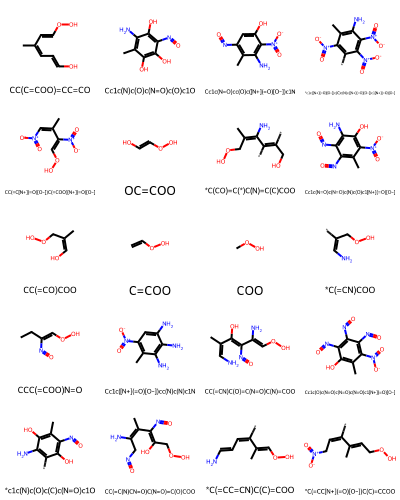

In [10]:
### Display molecules in mols_2 with a limit if needed ###

max_mols_to_draw = 20
mols_to_draw = mols_2[:min(len(mols_2), max_mols_to_draw)]
legends_to_draw = valid_smiles_2[:min(len(valid_smiles_2), max_mols_to_draw)]


img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=4, subImgSize=(100, 100),
                             legends=legends_to_draw,
                             maxMols=len(mols_to_draw),useSVG=True)
display(img)


In [11]:
len(mols_2)

8011

#2.1. Comparison of molecules mass with that in the toluene experiment

In [12]:
# Mass calculation in mols_2
calculated_mw_2 = []
for mol in mols_2:
  mw = Chem.Descriptors.ExactMolWt(mol)
  calculated_mw_2.append(mw)

# Comparison of mols_2 and experiment data
tolerance = 0.0000001  # 0.1ppm

matching_smiles_2 = []
matching_excel_info = []

#excel_mw_neg = exp_data['[M-H]'].tolist()
#excel_mw_neu = exp_data['Neutral_Mass'].tolist()
#excel_mw_pos = exp_data['[M+H]'].tolist()

for i, calculated_mw_value in enumerate(calculated_mw_2):
    for excel_mw_list, excel_column in zip(
        [excel_mw_neg, excel_mw_neu, excel_mw_pos], ['[M-H]', 'Neutral_Mass', '[M+H]']
    ):
        for j, excel_mw_value in enumerate(excel_mw_list):
            diff = abs(calculated_mw_value - excel_mw_value)

            if diff <= tolerance and valid_smiles_2[i] not in matching_smiles_2:
                matching_smiles_2.append(valid_smiles_2[i])

                # Get the row
                row_index = exp_data.index[exp_data[excel_column] == excel_mw_value].tolist()[0]
                matching_excel_info.append((row_index, excel_column))

                break

# Get all row in the Excel file
all_excel_indices = set(exp_data.index)

# Get the set of matching row
matching_indices_set = set(index for index, _ in matching_excel_info)

# Find the non-matching
non_matching_indices = all_excel_indices - matching_indices_set

# Matching percentage
matching_percentage = (len(matching_indices_set) / len(all_excel_indices)) * 100

print(f"Matching percentage: {matching_percentage:.2f}%")

Matching percentage: 6.35%


#3. Reactions after ring opening

In [13]:
### Next reactions after ring opening ###

chemical_space_3 = set(valid_smiles_2)
reacting_species_3 = {'O=O','[OH]','N([H])([H])[H]'}
num_iterations_3 = 1

In [14]:
reaction_rules_3 = [

    ### 1. Oxidation ###
    #1.1. Hydroperoxide to alcohol (OOH to OH)(n=2>>6.52%, n=3>>6.52%)
    AllChem.ReactionFromSmarts('[C:1][O][O]>>[C:1][O]'),

    #1.2. Alcohol to aldehyde(n=2>>6.86%, n=3>>6.86%)
    AllChem.ReactionFromSmarts('[C:1][OH]>>[C:1]=O'),

    #1.3. Alkene to Diol (n=1>>8.4%; n=2>>10.46%; n=3>>10.98%; n=4>>10.98%)
    AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1](O)-[C:2](O)'),

    #>>>n=2,n=3 for 1.1 + 1.2 + 1.3>> 14.07%

    ### 2. Hydroxylation ###
    #2.1. Add OH (oxidation of CH2 to alcohol) (n=1>>7.2%; n=2>>7.72%, n=3>>7.72%)
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH1:1](O)'),

    #2.2. General carbon hydroxylation (nw) n=1>>7.55%, n=>>8.92%, n=3>>10.12%, n=4>>10.81%, n=5>>11.49%, n=6>>12.35%, n=7>>12.69%, n=8>>crashed
    AllChem.ReactionFromSmarts('[C:1]>>[C:1](O)'),

    ### 3. Amidation ###
    #3.1. Alkyl amination: n=1>>, n=2>>6.52%, n=3>>6.52%
    AllChem.ReactionFromSmarts('[C:1]>>[C:1][NH2]'),

    ### 4. Nitration or Nitrosation ###
    #4.1. Alkyl nitration: n=1>>, n=2>>8.4%, n=3>>8.4%
    AllChem.ReactionFromSmarts('[C:1]>>[C:1][N+](=O)[O-]'),

    #4.2. Nitrosation: n=1>>, n=2>>6.52%, n=3>>6.52%
    AllChem.ReactionFromSmarts('[C:1]>>[C:1][N](=O)'),

    ### 5.Peroxide formation ###
    # n=2>>10.81%, n=2>>12.35%, n=3>>,n=4>>13.21%,n=5>>13.72%
    AllChem.ReactionFromSmarts('[C:1]>>[C:1]OO'),

                      ##### List of eliminated rules #####
    #AllChem.ReactionFromSmarts('[C:1](=O)>>[C:1](=O)[OH]'), # Aldehyde to Carboxylic acid: n=2>>6.35%
    #AllChem.ReactionFromSmarts('[CH:1]=O>>[C:1](=O)[OH]'),
    #AllChem.ReactionFromSmarts('[C:1](=O)[OH]>>[C:1](=O)[NH2]'),# Carboxylic acid → Amide: n=2>>6.35%
    #AllChem.ReactionFromSmarts('[C:1](=O)[NH2]>>[C:1][NH2]'), # Amide reduction: n=2>>6.35%
    #AllChem.ReactionFromSmarts('[N+](=O)[O-]>>[NH2]') # Nitro to amine: n=2>>6.35%
    #AllChem.ReactionFromSmarts('[N:1]=O>>[NH2:1]'), # Nitroso to amine: n=2>>6.35%
    #AllChem.ReactionFromSmarts('[C:1](=O)[C:2]>>[C:1]=O.[C:2]=O'), # Oxidative C–C bond break: n=2>>6.35%
    #AllChem.ReactionFromSmarts('[C:1](=O)[O][C:2]>>[C:1](=O)[OH].[C:2][OH]'), # Ester to acid + alcohol: n=2>>6.35%

]

In [15]:
reaction_history_3 = []

# Reactions
for _ in range(num_iterations_3):
    temp_new_products = set()
    for reactant_smiles in chemical_space_3.copy():
        reactant_mol = Chem.MolFromSmiles(reactant_smiles)
        if reactant_mol:

            # Apply reaction rules
            for rxn_index, rxn in enumerate(reaction_rules_3):
                possible_products = rxn.RunReactants((reactant_mol,))
                for prod_set in possible_products:
                    for prod in prod_set:
                        try:
                            prod_smiles = Chem.MolToSmiles(prod)
                            prod_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles), canonical=True)

                            if prod_smiles not in chemical_space_3:
                                temp_new_products.add(prod_smiles)
                                reaction_history_3.append((reactant_smiles, rxn_index, prod_smiles))
                        except:
                            pass

            # React with reacting species
            for species in reacting_species_3:
                try:
                    combined_smiles = reactant_smiles #+ "." + species
                    combined_mol = Chem.MolFromSmiles(combined_smiles)

                    if combined_mol:

                        temp_new_products.add(Chem.MolToSmiles(combined_mol))
                except:
                    pass

    chemical_space_3.update(temp_new_products)

    # Create mols_3 and valid_smiles_3 from chemical_space_3
    mols_3 = [Chem.MolFromSmiles(smi) for smi in chemical_space_3]
    valid_smiles_3 = list(chemical_space_3)

Streaming output truncated to the last 5000 lines.
[04:42:50] Explicit valence for atom # 1 C, 5, is greater than permitted
[04:42:50] Explicit valence for atom # 4 C, 5, is greater than permitted
[04:42:50] Explicit valence for atom # 7 C, 5, is greater than permitted
[04:42:50] Explicit valence for atom # 11 C, 5, is greater than permitted
[04:42:50] Explicit valence for atom # 1 C, 5, is greater than permitted
[04:42:50] Explicit valence for atom # 4 C, 5, is greater than permitted
[04:42:50] Explicit valence for atom # 7 C, 5, is greater than permitted
[04:42:50] Explicit valence for atom # 11 C, 5, is greater than permitted
[04:42:50] Explicit valence for atom # 1 C, 5, is greater than permitted
[04:42:50] Explicit valence for atom # 4 C, 5, is greater than permitted
[04:42:50] Explicit valence for atom # 7 C, 5, is greater than permitted
[04:42:50] Explicit valence for atom # 11 C, 5, is greater than permitted
[04:42:50] Explicit valence for atom # 1 C, 5, is greater than permitt

In [16]:
print(len(chemical_space_3))
print(len(mols_3))

98988
98988


#3.1. Comparison of molecules mass with that in the toluene experiment

In [17]:
# Mass of molecules in mols_3

calculated_mw_3 = []
for mol in mols_3:
  mw = Chem.Descriptors.ExactMolWt(mol)
  calculated_mw_3.append(mw)

## Comparison of simulation results and experiment data
tolerance = 0.0000001  # 0.1ppm

matching_smiles_3 = []
matching_excel_info = []  # Store the row indices from Excel

#excel_mw_neg = exp_data['[M-H]'].tolist()
#excel_mw_neu = exp_data['Neutral_Mass'].tolist()
#excel_mw_pos = exp_data['[M+H]'].tolist()

for i, calculated_mw_value in enumerate(calculated_mw_3):
    for excel_mw_list, excel_column in zip(
        [excel_mw_neg, excel_mw_neu, excel_mw_pos], ['[M-H]', 'Neutral_Mass', '[M+H]']
    ):
        for j, excel_mw_value in enumerate(excel_mw_list):
            diff = abs(calculated_mw_value - excel_mw_value)

            if diff <= tolerance and valid_smiles_3[i] not in matching_smiles_3:
                matching_smiles_3.append(valid_smiles_3[i])

                # Get the row
                row_index = exp_data.index[exp_data[excel_column] == excel_mw_value].tolist()[0]
                matching_excel_info.append((row_index, excel_column))

                break

# Get all row of data
all_excel_indices = set(exp_data.index)

# Get the set of matching
matching_indices_set = set(index for index, _ in matching_excel_info)

# Find the non-matching
non_matching_indices = all_excel_indices - matching_indices_set

# matching percentage
matching_percentage = (len(matching_indices_set) / len(all_excel_indices)) * 100

print(f"Matching percentage: {matching_percentage:.2f}%")
print(f'There are {len(matching_smiles_3)} molecules in matching_smiles_3')

Matching percentage: 10.63%
There are 25271 molecules in matching_smiles_3


#4. Pathways

Reaction pathway for *C(=C(O)CC)C(O)=C(N=O)C(OO)[N+](=O)[O-]:


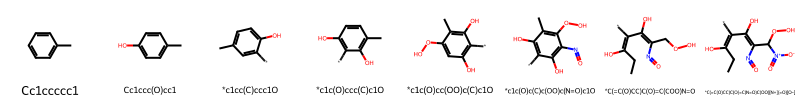

--------------------
Reaction pathway for *C(=CC)C(O)=C(*)C(N)=C(O)OO:


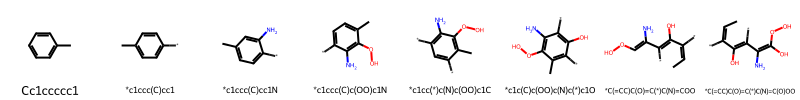

--------------------
Reaction pathway for *C(C=COO)=C(C(C)=CN)[N+](=O)[O-]:


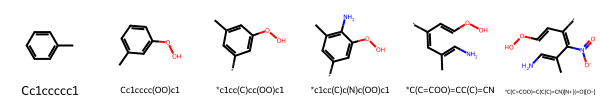

--------------------
Reaction pathway for C=C([N+](=O)[O-])C(O)(O)C(C)(O)C(=COO)[N+](=O)[O-]:


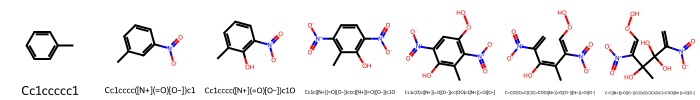

--------------------
Reaction pathway for *c1cc(COO)ccc1N=O:


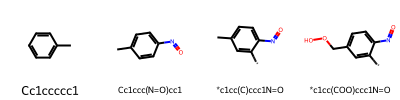

--------------------
Reaction pathway for *C(C(C)=COO)=C(C=C(O)[N+](=O)[O-])N=O:


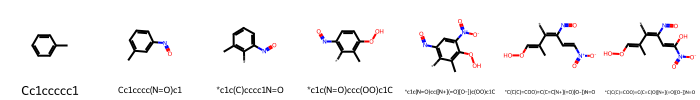

--------------------
Reaction pathway for *c1c(O)c(COO)c(N)c(O)c1[N+](=O)[O-]:


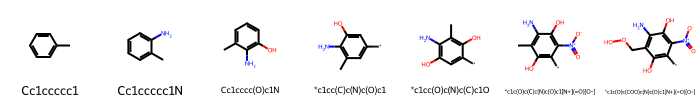

--------------------
Reaction pathway for *C(=C(C)C[N+](=O)[O-])C(=C(O)CO)[N+](=O)[O-]:


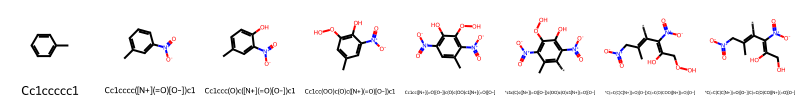

--------------------
Reaction pathway for *C(=CO)C(O)([N+](=O)[O-])C(C)(O)C(O)=COO:


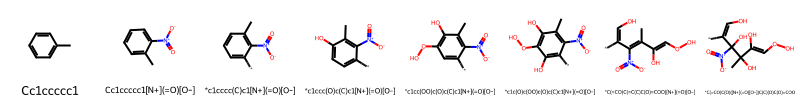

--------------------
Reaction pathway for Cc1cc([N+](=O)[O-])c([N+](=O)[O-])c(O)c1N=O:


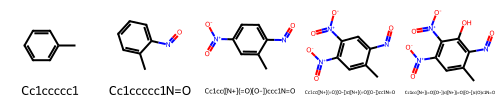

--------------------


In [18]:
# Visualization of pathways

num_smiles_to_trace = 10

# Trace reaction Function
def trace_reaction_path(target_product_smiles, reaction_history_1, reaction_history_3, reaction_history_2):
    """Traces the reaction pathway through both reaction histories """

    reaction_path = []
    current_product = target_product_smiles

    # Search in reaction_history_3
    for i in range(len(reaction_history_3) - 1, -1, -1):
        if reaction_history_3[i][2] == current_product:
            reaction_path.insert(0, reaction_history_3[i])
            current_product = reaction_history_3[i][0]
            break

    # Searching in reaction_history_2
    if reaction_path:
        for i in range(len(reaction_history_2) - 1, -1, -1):
            if reaction_history_2[i][2] == reaction_path[0][0]:
                reaction_path.insert(0, reaction_history_2[i])
                current_product = reaction_history_2[i][0]
                break

    # Searching in reaction_history_1
    if reaction_path:
        for i in range(len(reaction_history_1) - 1, -1, -1):
            if reaction_history_1[i][2] == reaction_path[0][0]:
                reaction_path.insert(0, reaction_history_1[i])
                current_product = reaction_history_1[i][0]

    # Tracing back
    while current_product != 'Cc1ccccc1':
        found_in_history = False
        for history in [reaction_history_3, reaction_history_2,reaction_history_1]:
            for i in range(len(history) - 1, -1, -1):
                if history[i][2] == current_product:
                    reaction_path.insert(0, history[i])
                    current_product = history[i][0]
                    found_in_history = True
                    break

            if found_in_history:
                break
        if not found_in_history:
            break

    return reaction_path


for i, product_smiles_3 in enumerate(matching_smiles_3):
    if i >= num_smiles_to_trace:
        break

    pathway = trace_reaction_path(product_smiles_3, reaction_history_1, reaction_history_3, reaction_history_2)

    if pathway:
        print(f"Reaction pathway for {product_smiles_3}:")

        # Collect molecules
        pathway_molecules = [Chem.MolFromSmiles(pathway[0][0])]
        legends = [pathway[0][0]]

        for step in pathway:
            reactant, rxn_index, product = step
            product_mol = Chem.MolFromSmiles(product)

            if product_mol is not None and product_mol not in pathway_molecules:
                pathway_molecules.append(product_mol)
                legends.append(product)

        img = Draw.MolsToGridImage(pathway_molecules, molsPerRow=len(pathway_molecules),
                                   subImgSize=(100, 100), legends=legends, useSVG=True)
        display(img)
        print("-" * 20)